# **Deep Convolutional GAN (DCGAN)**

## What is DCGANs?
- GANs is basically a framework where we simultaneously train two models include a generator (use to simulate the data distribution) and a discriminator (use to distinguish a sample is from the data distribution or the generator). This can be consider as a minimax game, where we train D (discriminator) to maximize the probability of assigning the correct label to both training examples and samples from G (generator) and we simultaneously train G to minimize $log(1-D(G(z)))$ (z is a random noise):

  $\min _G \max _D V(D, G)=\mathbb{E}_{\boldsymbol{x} \sim p_{\text {data }}(\boldsymbol{x})}[\log D(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]$

- DCGANs have the basic like GANs but there are some additions features, that they use 2 main layers are convolutional layer and transposed convolutional layer.
- Our goal is to find how to implement this in code with pytorch and CIFAR10 data set.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pickle
torch.manual_seed(0)

## Generator



In [3]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8, padding = 1),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding = 1, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN,
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.Tanh()
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        make a copy of that noise with width and height = 1 and channels = z_dim
        then returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cuda'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

## Discriminator

In [4]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels of the output image, a scalar
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=3, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, hidden_dim * 4),
            self.make_disc_block(hidden_dim * 4, hidden_dim * 8),
            self.make_disc_block(hidden_dim * 8, 1, kernel_size=2, stride=1, padding=0, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2,padding = 1, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN,
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
                 nn.Sigmoid()
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

Here's a test for your discriminator block:

## Training
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum term
  *   device: the device type


In [5]:
criterion = nn.BCELoss()
z_dim = 64
display_step = 50
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = CIFAR10(root='/content/drive/MyDrive/Colab_Notebooks/DCGANs/', train=True, download=False, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [ ]:
from torchsummary import summary
summary(gen, (z_dim,))
summary(disc, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 2, 2]         524,800
       BatchNorm2d-2            [-1, 512, 2, 2]           1,024
              ReLU-3            [-1, 512, 2, 2]               0
   ConvTranspose2d-4            [-1, 256, 4, 4]       2,097,408
       BatchNorm2d-5            [-1, 256, 4, 4]             512
              ReLU-6            [-1, 256, 4, 4]               0
   ConvTranspose2d-7            [-1, 128, 8, 8]         524,416
       BatchNorm2d-8            [-1, 128, 8, 8]             256
              ReLU-9            [-1, 128, 8, 8]               0
  ConvTranspose2d-10           [-1, 64, 16, 16]         131,136
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
  ConvTranspose2d-13            [-1, 3, 32, 32]           3,075
             Tanh-14            [-1, 3,

In [7]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 32, 32)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [8]:
gen.load_state_dict(torch.load("/content/drive/MyDrive/Colab_Notebooks/DCGANs/gen_ver3_2.pth"))
disc.load_state_dict(torch.load("/content/drive/MyDrive/Colab_Notebooks/DCGANs/disc_ver3_2.pth"))

<All keys matched successfully>

In [ ]:
# generator_losses = []
# discriminator_losses = []
with open('./drive/MyDrive/Colab Notebooks/generator_losses.pkl', 'rb') as file:
    generator_losses = pickle.load(file)
with open('./drive/MyDrive/Colab Notebooks/discriminator_losses.pkl', 'rb') as file:
    discriminator_losses = pickle.load(file)

In [ ]:
n_epochs = 20
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss)

        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track the loss to visualize.
        generator_losses.append(gen_loss.item())
        discriminator_losses.append(disc_loss.item())
        ## Visualization code ##
        if cur_step % display_step == 0:
            print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, n_epochs, disc_loss.item(), gen_loss.item(), disc_real_pred.mean().item(), disc_fake_pred.mean().item(), disc_fake_pred.mean().item()))
        if (cur_step % 500 == 0):
              show_tensor_images(fake)
              with open('./drive/MyDrive/Colab Notebooks/generator_losses.pkl', 'wb') as file:
                pickle.dump(generator_losses, file)
              with open('./drive/MyDrive/Colab Notebooks/discriminator_losses.pkl', 'wb') as file:
                pickle.dump(discriminator_losses, file)
        cur_step += 1
    torch.save(gen.state_dict(), "./drive/MyDrive/Colab Notebooks/gen_ver3_2.pth")
    torch.save(disc.state_dict(), "./drive/MyDrive/Colab Notebooks/disc_ver3_2.pth")


Output hidden; open in https://colab.research.google.com to view.

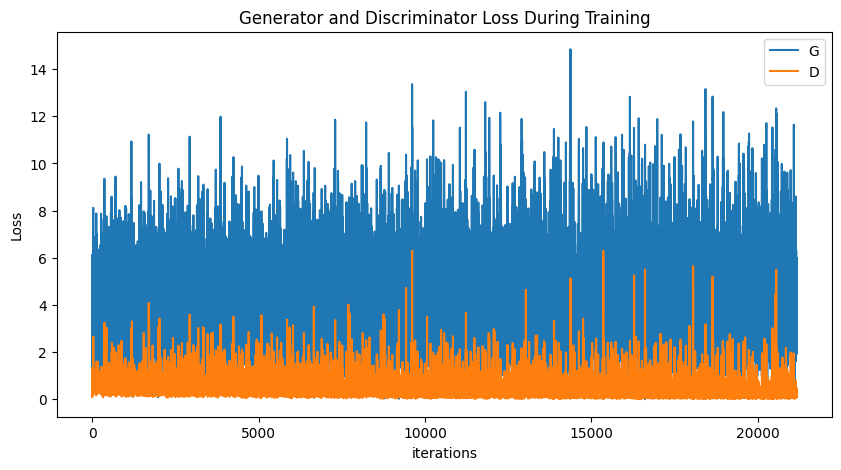

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_losses,label="G")
plt.plot(discriminator_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

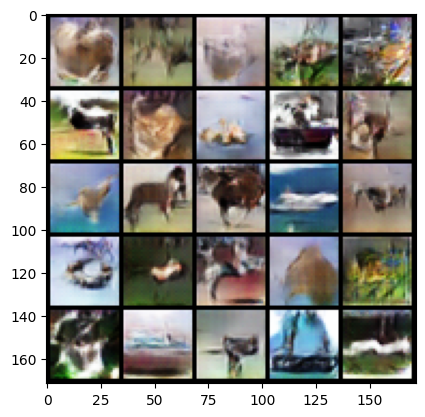

In [13]:
show_tensor_images(gen(get_noise(128, 64, device=device)))

FID, IS đo thử

In [23]:
# import tensorflow as tf
# import numpy as np
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.applications.inception_v3 import preprocess_input
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.layers import GlobalAveragePooling2D
# base_model = InceptionV3(weights='imagenet', include_top=False)
# x = base_model.output
# x = GlobalAveragePooling2D()(x)  # Add Global Average Pooling Layer
# feature_extraction_model = Model(inputs=base_model.input, outputs=x)

def preprocess_and_extract_features(img, feature_extraction_model):
    features = []
    # img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    features.append(feature_extraction_model.predict(img))
    return np.vstack(features)


In [24]:
import numpy as np
from scipy.linalg import sqrtm

def calculate_fid(real_features, fake_features):
    mean_real = np.mean(real_features, axis=0)
    mean_fake = np.mean(fake_features, axis=0)
    cov_real = np.cov(real_features, rowvar=False)
    cov_fake = np.cov(fake_features, rowvar=False)
    cov_sqrt = sqrtm(cov_real.dot(cov_fake))
    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real
    fid = np.sum((mean_real - mean_fake) ** 2) + np.trace(cov_real + cov_fake - 2.0 * cov_sqrt)
    return fid
real = None
for real, _ in dataloader:
    real = real.to(device)
    break
real_features = preprocess_and_extract_features(gen(get_noise(128, 64, device=device)), feature_extraction_model)
fake_features = preprocess_and_extract_features(real, feature_extraction_model)
fid_score = calculate_fid(real_features, fake_features)

TypeError: ignored